## Generating tap sounds

In [1]:
from scipy.io import wavfile as wav
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.signal import argrelextrema, find_peaks, peak_prominences, find_peaks_cwt
from sklearn.metrics import accuracy_score

In [2]:
def get_wav_mp3(mp3_file, wav_name):
    song = AudioSegment.from_mp3(mp3_file)
    new_song = song.export(wav_name, format="wav")
    #print("Exported file as: " + wav_name)
    return new_song
    
def get_wav_mp4(mp4_file, wav_name):
    song = AudioSegment.from_file(mp4_file, "mp4")
    new_song = song.export(wav_name, format="wav")
    #print("Exported file as: " + wav_name)
    return new_song

def build_list(artist, clip_number, length):
    i = 1
    artist_list = []
    while i <= length :
        name = artist + "/" + str(clip_number) + "/" +str(i) + ".wav"
        artist_list.append(name)
        i += 1
    return artist_list

def split_silence_chunks(wavfile, silence_length, threshold, file_names_list):
    sound_file = AudioSegment.from_wav(wavfile)
    audio_chunks = split_on_silence(sound_file, 
                        min_silence_len=silence_length,
                        silence_thresh=threshold)
    for i in range (len(audio_chunks)) :
        chunk = audio_chunks[i]
        chunk.export(file_names_list[i], format='wav')
    print("Exported " + str(len(audio_chunks)) + " files")
    
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

## Getting started with shuffles
(Source : https://www.youtube.com/watch?v=aJa3DYnAjqU )

In [3]:
get_wav_mp4('Shuffle/Shuffle.mp4', 'Shuffle/Shuffle.wav');

FileNotFoundError: [Errno 2] No such file or directory: 'Shuffle/Shuffle.mp4'

Manually extract the relevant clip. 
<br/>Set channel to 1 (mono).

In [ ]:
song = AudioSegment.from_wav('Shuffle/Shuffle.wav')
song = song.set_channels(1)
start = 30 * 1000
end = 34 * 1000
three_shuffles = song[start:end]
three_shuffles.export('Shuffle/1/three_shuffles.wav', format="wav");

In [ ]:
three_shuffles

Split up the audio into its components. This could also be done with split on silence. 
<br/> Split on time needs to be fixed. (Index error)

In [ ]:
shuffle_1 = three_shuffles[:(three_shuffles.duration_seconds/3)*1000]
shuffle_2 = three_shuffles[(three_shuffles.duration_seconds/3)*1000:(three_shuffles.duration_seconds/3)*2000]
shuffle_3 = three_shuffles[(three_shuffles.duration_seconds/3)*2000:]

In [ ]:
shuffle_1.export('Shuffle/1/1.wav', format="wav")
shuffle_2.export('Shuffle/1/2.wav', format="wav")
shuffle_3.export('Shuffle/1/3.wav', format="wav");

## Cutting the into/outro silence out of the clips

In [ ]:
path_list = [shuffle_1, shuffle_2, shuffle_3]

for i in path_list:
    sound = i
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    trimmed_sound.export('Shuffle/Split/1/'+ str(path_list.index(i)+1)+ '.wav', format='wav')

## Now with ball change
(Source: https://www.youtube.com/watch?v=hi0wkLqPGR0 )

In [ ]:
get_wav_mp4('Ball_change/Ball_change.mp4', 'Ball_change/Ball_change.wav');

Manually extract the relevant clip. 
<br/>Set channel to 1 (mono).

In [ ]:
song = AudioSegment.from_wav('Ball_change/Ball_change.wav')
song = song.set_channels(1)
start = 48.5 * 1000
end = 52 * 1000
three_ball_changes = song[start:end]
three_ball_changes.export('Ball_change/1/three_ball_changes.wav', format="wav");

In [ ]:
three_ball_changes

In [ ]:
ball_change_1 = three_ball_changes[:(three_ball_changes.duration_seconds/3)*1000]
ball_change_2 = three_ball_changes[(three_ball_changes.duration_seconds/3)*1000:(three_ball_changes.duration_seconds/3)*2000]
ball_change_3 = three_ball_changes[(three_ball_changes.duration_seconds/3)*2000:]

In [ ]:
ball_change_1.export('Ball_change/1/1.wav', format="wav")
ball_change_2.export('Ball_change/1/2.wav', format="wav")
ball_change_3.export('Ball_change/1/3.wav', format="wav");

## Cutting the into/outro silence out of the clips

In [ ]:
path_list = [ball_change_1, ball_change_2, ball_change_3]

for i in path_list:
    sound = i
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    trimmed_sound.export('Ball_change/Split/1/'+ str(path_list.index(i)+1) + '.wav', format='wav')

## Generating a combination

In [ ]:
combi_1 = (shuffle_1 + ball_change_1) * 2 + (shuffle_1 + (ball_change_1 * 3))
combi_1.export('Combi/1.wav', format='wav');
#(shuffle_1*20).speedup(playback_speed=2.5, crossfade=0)

In [ ]:
combi_2 = shuffle_2 * 4 + ball_change_2 * 4
combi_2.export('Combi/2.wav', format='wav');

In [ ]:
combi_3 = combi_1 + combi_2
combi_3.export('Combi/3.wav', format='wav');

In [ ]:
combi_3

In [ ]:
combi_basic = shuffle_1 + ball_change_1
combi_basic.export('Combi/Basic.wav', format='wav');

## Splitting up combination on silence
This could be a good strategy for processing generated data
<br/> Note the loudness in the samples
<br/> Chose reasonably large list size, too big is OK, too small is a problem
<br/> Minimum amount of silence to make a split is 250 msec

In [ ]:
combi_3.dBFS

In [ ]:
split_silence_chunks('Combi/1.wav', 250, -42, build_list(artist='Combi/Chunks', clip_number=1, length=16))

In [ ]:
split_silence_chunks('Combi/2.wav', 250, -42, build_list(artist='Combi/Chunks', clip_number=2, length=16))

In [ ]:
split_silence_chunks('Combi/3.wav', 250, -42, build_list(artist='Combi/Chunks', clip_number=3, length=16))

In [ ]:
split_silence_chunks('Combi/Basic.wav', 250, -42, build_list(artist='Combi/Chunks', clip_number='Basic', length=16))

## Visualizing the audio data

In [4]:
def plot_waves (file, title):
    # Read the wav file (mono)
    samplingFrequency, signalData = wav.read(file)
    
    # Plot the signal read from wav file
    plt.subplot(211)
    plt.title(title)
    #plt.plot(signalData[:,1])
    plt.plot(signalData[:])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(212)
    #plt.specgram(signalData[:,1],Fs=samplingFrequency)
    plt.specgram(signalData[:],Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    return plt.show()

In [ ]:
plot_waves('Shuffle/1/1.wav', 'Shuffle')

In [ ]:
plot_waves('Ball_change/1/3.wav', 'Ball change')

In [ ]:
plot_waves('Combi/Basic.wav', 'Shuffle ball change')

In [ ]:
plot_waves('Combi/3.wav', 'Longer combination')

So, the length of the array of samples is equal to the duration in seconds multiplied by the frame (sample) rate

In [ ]:
len(shuffle_1.get_array_of_samples()), shuffle_1.duration_seconds * shuffle_1.frame_rate

In [ ]:
len(combi_3.get_array_of_samples()), combi_3.duration_seconds * combi_3.frame_rate

## Feature Extraction 

In [ ]:
samplingFrequency, signalData = wav.read('Combi/Chunks/1/1.wav')
#print(len(signalData[:]))
pos_signalData = signalData[:].copy()

# Remove negative values
pos_signalData = pos_signalData[pos_signalData >= 0]
# Remove beginning and ending "noise"


plt.subplot(211)
plt.plot(pos_signalData[:])
plt.xlabel('Sample')
plt.ylabel('|Amplitude|')  

plt.subplot(212)
plt.plot(signalData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude');

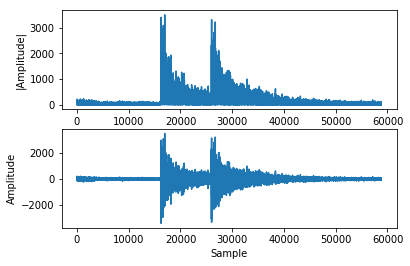

In [6]:
# Approach: reformatting the amplitude graph by taking the absolute value, and starting the frame with the first peak
# Data: shuffle_1

samplingFrequency, signalData = wav.read('../../Source/Shuffle/1/1.wav')
#print(len(signalData[:]))
pos_signalData = signalData[:].copy()
for i in range (len(signalData[:])):
    if signalData[i] < 0 :
        pos_signalData[i] = np.absolute(signalData[i])
    else : 
        pos_signalData[i] = signalData[i]
    



plt.subplot(211)
plt.plot(pos_signalData[:])
plt.xlabel('Sample')
plt.ylabel('|Amplitude|')  

plt.subplot(212)
plt.plot(signalData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude');

### Peak Analysis

x : sequence
A signal with peaks.
<br/><br/>height : number or ndarray or sequence, optional
Required height of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required height.
<br/><br/>threshold : number or ndarray or sequence, optional
Required threshold of peaks, the vertical distance to its neighbouring samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.
<br/><br/>distance : number, optional
Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. The removal order is explained in the notes section.
<br/><br/>prominence : number or ndarray or sequence, optional
Required prominence of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.
<br/><br/>width : number or ndarray or sequence, optional
Required width of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.
<br/><br/>wlen : number, optional
Used for calculation of the peaks prominences, thus it is only used if one of the arguments prominence or width is given. See argument wlen in peak_prominences for a full description of its effects.
<br/><br/>rel_height : float, optional
Used for calculation of the peaks width, thus it is only used if width is given. See argument rel_height in peak_widths for a full description of its effects.

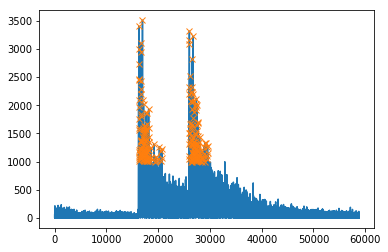

In [7]:
# Find all peaks above 1000

x = pos_signalData[:]
peaks, _ = find_peaks(x, height=1000)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

[ 615  617  547  505  503  905  514  992  639  835 1000  544  567  610
  510  503  533  948  734  905  570  636  578  905  705  694  500 1000
  519  556  505  642  784  687  512  708  679  626  649  703  657  611
  797  535  754  786  744  671  590  590  530  530  713  630  746  604
  534  603  620  680  933  529  551  709  794  528  513  545  976  540
  559  641  693  535  525  687  970  859  503  844  883  952  522  931
  754  553  553  514]


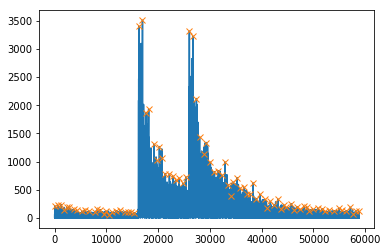

In [8]:
# Peaks with minimum distance of 500 

peaks, _ = find_peaks(x, distance=500)
print(np.diff(peaks))

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()


In [9]:
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
prominences
peak_prominences(x, peaks)


(array([19., 83.,  7., ..., 12., 58., 32.]),
 array([    2,     2,    13, ..., 58785, 58785, 58795]),
 array([    7,    15,    15, ..., 58789, 58799, 58799]))

In [10]:
peak_prominences(x, peaks, wlen=3.1)

(array([19., 28.,  7., ..., 12., 11., 32.]),
 array([    3,     8,    13, ..., 58785, 58789, 58795]),
 array([    7,    12,    15, ..., 58789, 58793, 58799]))

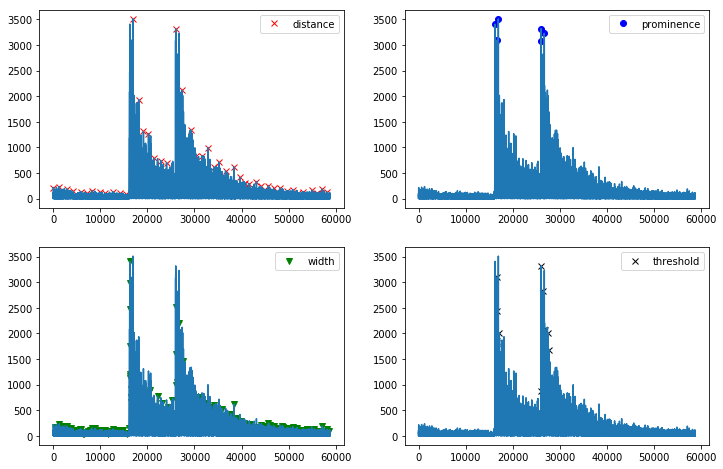

In [20]:

x = pos_signalData[:]
peaks, _ = find_peaks(x, distance=1000)
peaks2, _ = find_peaks(x, prominence=3000)      
peaks3, _ = find_peaks(x, width=10)
peaks4, _ = find_peaks(x, threshold=300)    
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "vg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()


In [19]:
peaks2

array([16258, 16697, 16963, 25998, 26024, 26727])

## Same approaches with different data

In [ ]:
# Approach: reformatting the amplitude graph
# Data: ball_change_1

samplingFrequency, signalData = wav.read('Ball_change/1/1.wav')
#print(len(signalData[:]))
pos_signalData = signalData[:].copy()
for i in range (len(signalData[:])):
    if signalData[i] < 0 :
        pos_signalData[i] = np.absolute(signalData[i])
    else : 
        pos_signalData[i] = signalData[i]

plt.subplot(211)
plt.plot(pos_signalData[:])
plt.xlabel('Sample')
plt.ylabel('|Amplitude|')  

plt.subplot(212)
plt.plot(signalData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude');

In [ ]:
numbers_2 = np.array(ball_change_1.get_array_of_samples())
df_2 = pd.DataFrame(numbers_2)
df_2.describe()

## Organizing audio clips in a DataFrame

In [ ]:
from pathlib import Path
path_col = []

I'm doing this 3 times, changing the path for each folder (Shuffle/1, Ball_change/1, Combi).
<br/> Hopefully, I'll find a more elegant solution.

In [ ]:
pathlist = Path('Shuffle/Split').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [ ]:
pathlist = Path('Ball_change/Split').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [ ]:
pathlist = Path('Combi/Chunks').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)
    path_col.sort(key=str)

In [ ]:
tap = pd.DataFrame({'Path':path_col})

Set all clips to 'mono': **handled when initial wav files are loaded**

Pimp out DataFrame with other relevant details
<br/> Single line loops 'cause I'm a *gangsta*!

In [ ]:
# 1 for shuffle, 0 for ball change
tap['Label'] = [0,0,0,1,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,1,1]
tap['Length'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).duration_seconds for idx in range(len(tap))] 
tap['Channels'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).channels for idx in range(len(tap))]
tap['Sample_rate'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).frame_rate for idx in range(len(tap))]
tap['Bit_depth'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).sample_width*8 for idx in range(len(tap))]
tap['Mean'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[1].item() for idx in range(len(tap))]
tap['Std'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[2].item() for idx in range(len(tap))]
tap['Min'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[3].item() for idx in range(len(tap))]
tap['Q_1'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[4].item() for idx in range(len(tap))]
tap['Q_2'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[5].item() for idx in range(len(tap))]
tap['Q_3'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[6].item() for idx in range(len(tap))]
tap['Max'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[7].item() for idx in range(len(tap))]


In [ ]:
tap

## Quick and dirty test with mini-dataset

In [ ]:
data = tap.iloc[:,6:].values
labels = tap['Label']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

In [ ]:
predict = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)

In [ ]:
results = pd.DataFrame()
results['Predict'] = predict
results['True'] = y_test.values
results['Prob_0'] = proba[:,0]

In [ ]:
results

In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_test, predict)))

## Stolen code to test out

In [ ]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

sound_file_paths = ['../../Source/Shuffle/1/1.wav', '../../Source/Normal/Shuffle/1/1.wav']

sound_names = ['Shuffle as is', 'Shuffle normalized']

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)